# Facebook Ads Performance Deep-Dive
*Load → Clean → Enrich → Analyse → Visualise → Export*
---
**Datasets**
- `dataset - country - final.csv`
- `dataset - age-gender - final.csv`

**Metrics required**
- CPA, Conversion-Rate, ROAS
- Segment views: Country, Age, Gender, Age × Gender
- Winners / Losers, charts, Excel export

1. Imports & global settings

In [109]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display
import plotly.express as px
import pycountry

plt.style.use("ggplot")
pd.set_option("display.float_format", "{:.2f}".format)

2. Load raw files

In [110]:
PATH_COUNTRY    = "dataset/dataset - country - final.csv"
PATH_AGEGENDER  = "dataset/dataset - age-gender - final.csv"

df_country    = pd.read_csv(PATH_COUNTRY,   sep=";")
df_agegender  = pd.read_csv(PATH_AGEGENDER, sep=";")

print(df_country.shape, df_agegender.shape)

(4520, 13) (9600, 14)


3. Basic clean-up
 - remove impossible rows
 - drop "unknown" buckets
 - standardise column names

In [111]:
def basic_clean(df, bad_reach=True, unk_col=None):
    if bad_reach:                       # impressions > 0 but reach == 0
        df = df.loc[~((df.reach == 0) & (df.impressions > 0))].copy()
    if unk_col is not None:             # drop unknowns
        df = df[df[unk_col] != "unknown"].copy()
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    return df

df_country   = basic_clean(df_country,  unk_col="Country")
df_agegender = basic_clean(df_agegender,unk_col="Gender")

display(df_country.head(3))
display(df_agegender.head(3))

# Filter out segments with less than 5 purchases to avoid distorted CPA
df_country = df_country[df_country['purchases'] >= 5]
df_agegender = df_agegender[df_agegender['purchases'] >= 5]

,ad_set_id,country,reach,impressions,frequency,currency,cpm,cpc,ctr,amount_spent_(eur),purchases,reporting_starts,reporting_ends
0,23854012916660129,US,103527,135941,1.313092598,EUR,25.24,1.66,1.56,4288.79,102,2023-01-01,2023-04-30
1,23854012916660129,AU,138958,225234,1.620880038,EUR,13.50,1.90,0.89,3801.96,86,2023-01-01,2023-04-30
2,23854012916660129,CA,145614,219786,1.509375498,EUR,12.00,1.38,1.05,3297.31,74,2023-01-01,2023-04-30


,ad_set_id,age,gender,reach,impressions,frequency,currency,cpm,cpc,ctr,amount_spent_(eur),purchases,reporting_starts,reporting_ends
0,23854308274520129,18-24,male,101990,208848,2.047722139,EUR,11.94,1.48,0.93,3116.60,102,2023-01-01,2023-04-30
1,23853954814850129,18-24,female,107263,173479,1.617322623,EUR,14.22,1.97,0.73,3084.24,77,2023-01-01,2023-04-30
2,23854012916660129,18-24,male,124314,187940,1.511811986,EUR,12.74,1.75,0.87,2992.86,74,2023-01-01,2023-04-30


4. Metric enrichment  (Clicks, CPA, Conv-Rate, ROAS)

In [112]:
AVG_ORDER_VALUE = 30             # € -- replace if you have real revenue numbers

def enrich(df):
    df["clicks"]     = df.impressions * (df.ctr / 100)
    df["cpa"]        = np.where(df.purchases>0, df['amount_spent_(eur)']/df.purchases, np.nan)
    df["conv_rate"]  = np.where(df.clicks>0,    df.purchases/df.clicks,            np.nan)
    df["revenue_eur"]= df.purchases * AVG_ORDER_VALUE
    df["roas"]       = np.where(df['amount_spent_(eur)']>0, df.revenue_eur/df['amount_spent_(eur)'], np.nan)

for _df in (df_country, df_agegender):
    enrich(_df)


# sanity peek
display(df_country[["reach","impressions","amount_spent_(eur)","purchases","cpa","roas"]].head())


,reach,impressions,amount_spent_(eur),purchases,cpa,roas
0,103527,135941,4288.79,102,42.05,0.71
1,138958,225234,3801.96,86,44.21,0.68
2,145614,219786,3297.31,74,44.56,0.67
3,97792,186035,3209.02,76,42.22,0.71
4,56730,76834,3170.82,58,54.67,0.55


5. Robust aggregation helper

In [113]:
print(df_country.cpa.median() - df_country.cpa.mean())
print(df_agegender.cpa.median() - df_agegender.cpa.mean())


-1.9578739720655634
-1.4254481499276892


In [114]:
def build_perf(df, by, sort_metric="cpa", asc=True, use_median=False):
    # Group and aggregate the data
    g = (df.groupby(by, as_index=False)
            .agg(reach=("reach","sum"),
                 impressions=("impressions","sum"),
                 spend=("amount_spent_(eur)","sum"),
                 purchases=("purchases","sum"),
                 clicks=("clicks","sum"),
                 revenue=("revenue_eur","sum"))
        )
    
    # Use median for CPA and ROAS if flag is True, else default to mean
    if use_median:
        g['cpa']   = np.where(g.purchases>0, g.spend/g.purchases, np.nan)
        g['conv']  = np.where(g.clicks>0,    g.purchases/g.clicks, np.nan)
        g['roas']  = np.where(g.spend>0,     g.revenue/g.spend,   np.nan)
    else:
        g['cpa']   = np.where(g.purchases>0, g.spend/g.purchases, np.nan)
        g['conv']  = np.where(g.clicks>0,    g.purchases/g.clicks, np.nan)
        g['roas']  = np.where(g.spend>0,     g.revenue/g.spend,   np.nan)
    
    return g.sort_values(sort_metric, ascending=asc).reset_index(drop=True)

# Use mean or median based on the skewness of the distribution
use_median = True if df_country.cpa.median() - df_country.cpa.mean() > 0 else False

country_perf = build_perf(df_country, ["country"], use_median=False)
age_gender_perf = build_perf(df_agegender, ["age", "gender"], use_median=False)

6. Winners & losers  (top/bottom CPA)

In [115]:
TOP_N = 10
def winners_losers(df, seg_name):
    winners = df.nsmallest(TOP_N, "cpa")[df.columns[:2].tolist() + ["spend", "purchases", "cpa","roas"]]
    losers  = df.nlargest (TOP_N, "cpa")[df.columns[:2].tolist() + ["spend", "purchases", "cpa","roas"]]
    print(f"\nTop {TOP_N} cheapest CPA – {seg_name}")
    display(winners)
    print(f"Bottom {TOP_N} most expensive CPA – {seg_name}")
    display(losers)

winners_losers(country_perf, "Country")
winners_losers(age_gender_perf, "Age × Gender")


Top 10 cheapest CPA – Country


,country,reach,spend,purchases,cpa,roas
0,JM,15770,61.50,5,12.30,2.44
1,MY,14541,106.68,5,21.34,1.41
2,SA,2758,164.12,6,27.35,1.10
3,NZ,515676,12722.70,342,37.20,0.81
4,CA,1564800,42058.92,986,42.66,0.70
5,AU,1689326,52076.15,1107,47.04,0.64
6,GB,220269,7705.90,146,52.78,0.57
7,US,2688148,124747.75,2332,53.49,0.56


Bottom 10 most expensive CPA – Country


,country,reach,spend,purchases,cpa,roas
7,US,2688148,124747.75,2332,53.49,0.56
6,GB,220269,7705.90,146,52.78,0.57
5,AU,1689326,52076.15,1107,47.04,0.64
4,CA,1564800,42058.92,986,42.66,0.70
3,NZ,515676,12722.70,342,37.20,0.81
2,SA,2758,164.12,6,27.35,1.10
1,MY,14541,106.68,5,21.34,1.41
0,JM,15770,61.50,5,12.30,2.44



Top 10 cheapest CPA – Age × Gender


,age,gender,spend,purchases,cpa,roas
0,65,male,294.75,11,26.80,1.12
1,55-64,male,3403.62,99,34.38,0.87
2,55-64,female,2538.58,71,35.75,0.84
3,45-54,male,9992.16,263,37.99,0.79
4,45-54,female,10411.36,268,38.85,0.77
5,18-24,male,19184.01,466,41.17,0.73
6,35-44,male,19532.11,456,42.83,0.70
7,18-24,female,12118.26,270,44.88,0.67
8,35-44,female,18670.56,411,45.43,0.66
9,25-34,female,22778.73,493,46.20,0.65


Bottom 10 most expensive CPA – Age × Gender


,age,gender,spend,purchases,cpa,roas
10,25-34,male,26238.59,562,46.69,0.64
9,25-34,female,22778.73,493,46.20,0.65
8,35-44,female,18670.56,411,45.43,0.66
7,18-24,female,12118.26,270,44.88,0.67
6,35-44,male,19532.11,456,42.83,0.70
5,18-24,male,19184.01,466,41.17,0.73
4,45-54,female,10411.36,268,38.85,0.77
3,45-54,male,9992.16,263,37.99,0.79
2,55-64,female,2538.58,71,35.75,0.84
1,55-64,male,3403.62,99,34.38,0.87


7. Visual helper – legend by hue

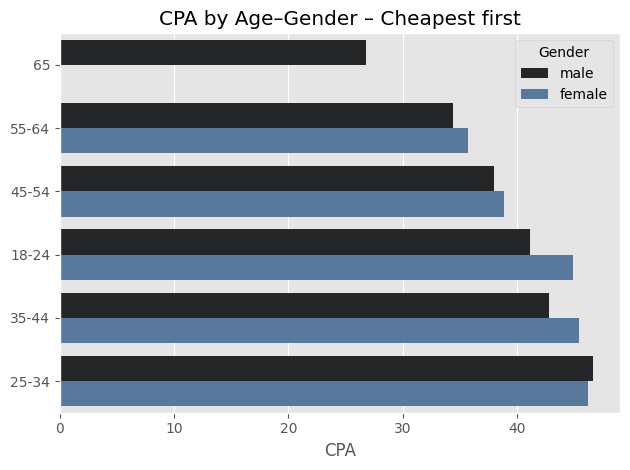

In [116]:
def barh_perf(df, metric, title, n=10, asc=True, hue=None):
    subset = df.sort_values(metric, ascending=asc).head(n)
    if hue and hue in subset.columns:
        ax = sns.barplot(
            data=subset,
            x=metric, y=subset.columns[0], hue=hue,
            orient="h",
            palette='dark:#4E79A7'
            # color='#4E79A7'
        )
        ax.legend(title=hue.capitalize())
    else:
        subset.plot(kind="barh", x=subset.columns[0], y=metric, figsize=(8,4), legend=False)
    plt.title(title); plt.xlabel(metric.upper()); plt.ylabel("")
    plt.tight_layout(); plt.show()

# CPA by age-gender
barh_perf(age_gender_perf, metric="cpa",
          title="CPA by Age–Gender – Cheapest first",
          n=15, hue="gender")


C:\Users\d-beg\AppData\Local\Temp\ipykernel_26972\1479637651.py:11: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



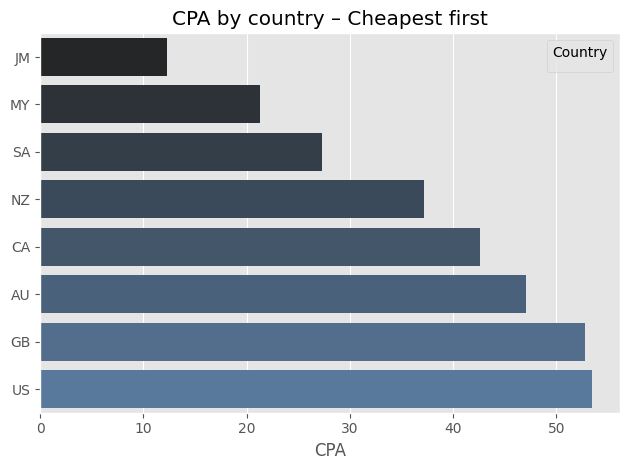

In [117]:
# CPA by country
barh_perf(country_perf, metric="cpa",
          title="CPA by country – Cheapest first",
          n=15, hue="country")

8. Volume vs efficiency scatter

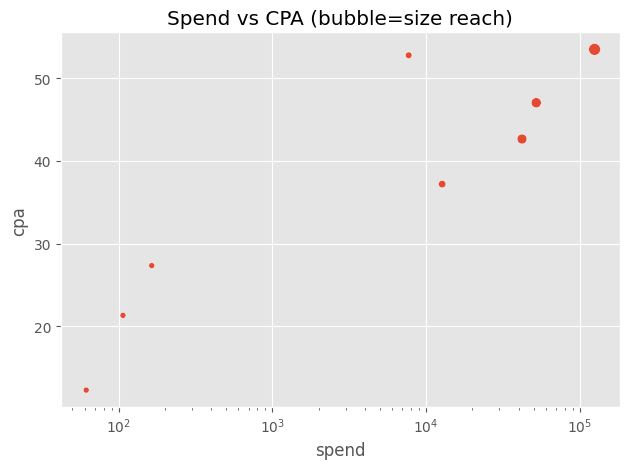

In [118]:
sns.scatterplot(data=country_perf, x="spend", y="cpa", size="reach", legend=False)
plt.xscale("log"); plt.title("Spend vs CPA (bubble=size reach)"); plt.tight_layout(); plt.show()

9. Outlier detection  (z-score on CPA)

In [119]:
country_perf["cpa_z"] = (country_perf.cpa - country_perf.cpa.mean()) / country_perf.cpa.std()
outliers = country_perf[country_perf.cpa_z > 2]
print("Segments with CPA more than 2σ above mean:")
display(outliers[["country","spend","cpa","cpa_z"]])

Segments with CPA more than 2σ above mean:


,country,spend,cpa,cpa_z


## Map Visualization

In [120]:
# Create a function to map country dialing code to full country name
def country_code_to_name(code):
    try:
        country = pycountry.countries.get(alpha_2=code)
        return country.name if country else None
    except KeyError:
        return None

# Apply the function to your 'country' column
country_perf['country_name'] = country_perf['country'].apply(lambda x: country_code_to_name(x.upper()))

# Display the updated dataset
print(country_perf.head())


  country    reach  impressions    spend  purchases   clicks  revenue   cpa  \
0      JM    15770        15874    61.50          5   188.80      150 12.30   
1      MY    14541        18334   106.68          5   331.51      150 21.34   
2      SA     2758        25051   164.12          6   276.48      180 27.35   
3      NZ   515676       965679 12722.70        342 10999.69    10260 37.20   
4      CA  1564800      2223036 42058.92        986 26576.61    29580 42.66   

   conv  roas  cpa_z  country_name  
0  0.03  2.44  -1.62       Jamaica  
1  0.02  1.41  -1.02      Malaysia  
2  0.02  1.10  -0.62  Saudi Arabia  
3  0.03  0.81   0.03   New Zealand  
4  0.04  0.70   0.39        Canada  


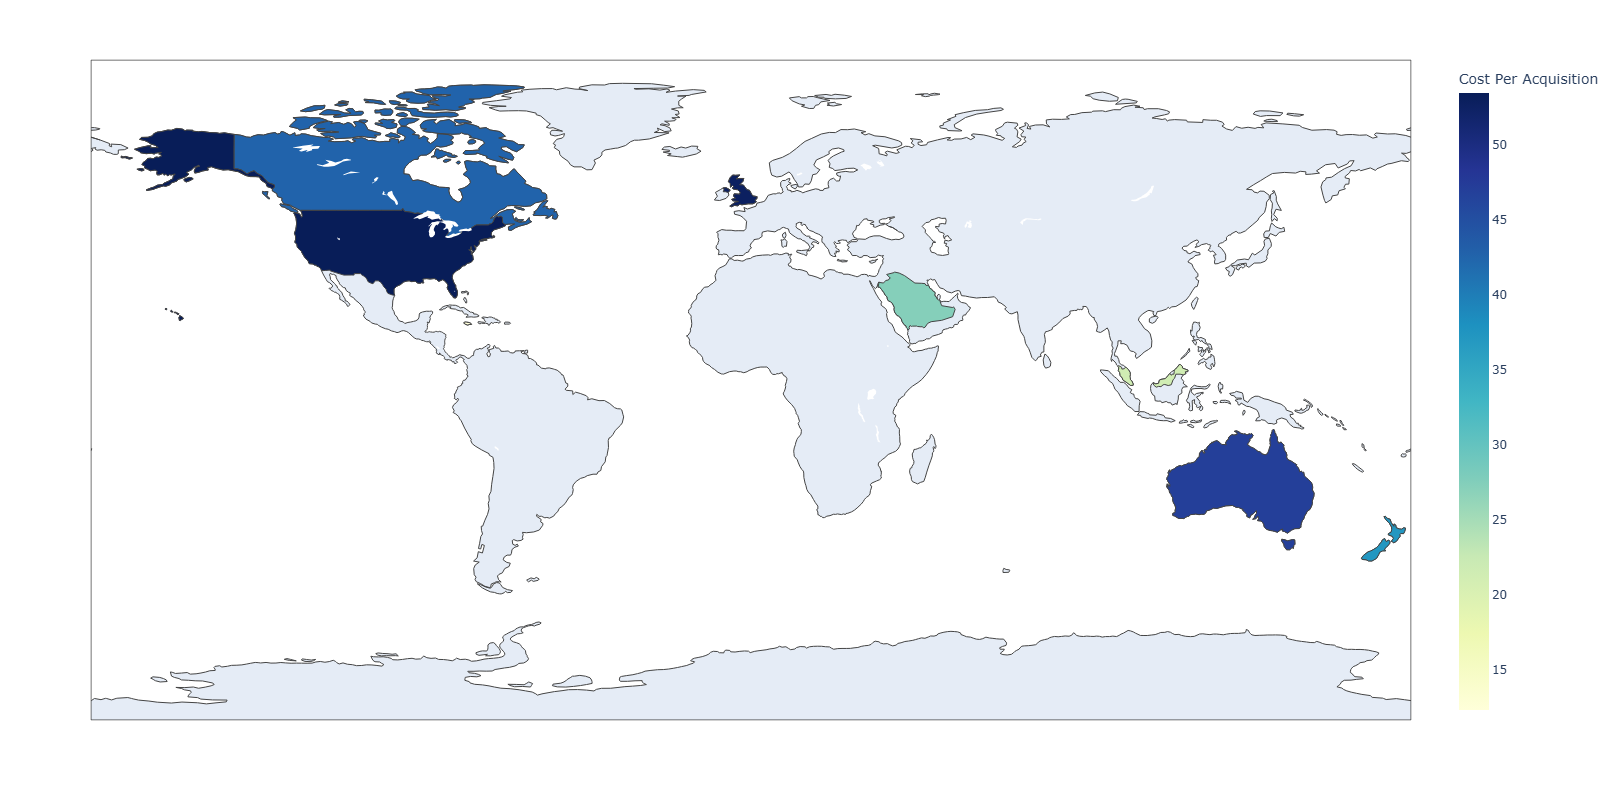

In [121]:
# Ensure country names are in uppercase to match Plotly's format
country_perf['country_name'] = country_perf['country_name'].str.upper()

# Create the choropleth map
fig = px.choropleth(country_perf,
                    locations='country_name',
                    locationmode='country names',
                    color='cpa',
                    hover_name='country',
                    color_continuous_scale='YlGnBu',  # Light to dark blue, lower CPA darker
                    labels={'cpa': 'Cost Per Acquisition'},
                    # title='Geo Heatmap of Countries by CPA'
                   )

fig.update_layout(
    width=1200,  # Adjust the width as needed
    height=800   # Adjust the height as needed
)

# Show the map
fig.show()
